In [1]:
import pandas as pd

In [2]:
import pandas as pd

# อ่านไฟล์ CSV
df = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv")

# แสดงตัวอย่างข้อมูล 5 แถวแรก
df.head()
 

,date_only,humidity,pm_10,pm_2_5,temperature
0,2021-08-19,89.236806,8.381918,7.086071,25.828308
1,2021-08-20,85.508983,7.939229,6.924858,27.348182
2,2021-08-21,86.817903,6.851081,5.991887,27.076012
3,2021-08-22,84.270087,8.187138,7.371436,27.871324
4,2021-08-23,82.809112,4.494782,3.834712,27.138680


In [3]:
#Regression

import pandas as pd
from pycaret.regression import *

# 1) อ่านข้อมูล
df = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv")

# 2) แปลง timestamp เป็น datetime แล้วเรียงตามเวลา
df['date_only'] = pd.to_datetime(df['date_only'])
df.sort_values(by='date_only', inplace=True)

# 3) สร้างคอลัมน์วันแบบตัวเลข (ordinal) เพื่อให้โมเดลจับลำดับของวันได้ง่ายขึ้น
df['date_only_ordinal'] = df['date_only'].map(pd.Timestamp.toordinal)

# 4) ในที่นี้ เราจะทำนาย pm_2_5 โดยใช้ฟีเจอร์ 4 ตัว: [timestamp_ordinal, humidity, pm_10, temperature]
# สร้าง DataFrame ใหม่ที่มีเฉพาะฟีเจอร์ + target
data = df[['date_only_ordinal', 'humidity', 'pm_10', 'temperature', 'pm_2_5']].copy()

# 5) ตั้งค่า PyCaret ในโหมด Regression
#    - target = 'pm_2_5'
#    - fold_strategy = 'timeseries' เพื่อบอกให้ PyCaret split ข้อมูลตามเวลา
#    - fold = 3 (หรือกำหนดเองได้)
#    - session_id = 123 (เพื่อความสามารถในการ reproduce)
reg_setup = setup(
    data=data,
    target='pm_2_5',
    fold_strategy='timeseries',
    fold=3,
    session_id=123,
    numeric_features=['date_only_ordinal', 'humidity', 'pm_10', 'temperature'],
    data_split_shuffle=False,  # ✅ ปิดการสุ่มข้อมูลตอนแบ่ง train/test
    fold_shuffle=False  # ✅ ปิดการ shuffle ข้อมูลใน cross-validation
)


# 6) เปรียบเทียบโมเดลต่าง ๆ เพื่อดูว่าโมเดลไหนแม่นที่สุด (ใช้ค่า default metric เช่น R2, RMSE, MAE)
best_model = compare_models()

# 7) ปรับแต่งโมเดลที่เลือก (tune) หรือสร้างโมเดลเอง
# tuned_model = tune_model(best_model)

# 8) เมื่อได้โมเดลที่พอใจแล้ว ทำการ final เพื่อเตรียมใช้งานจริง
final_model = finalize_model(best_model)

# 9) ประเมินโมเดลบนชุดข้อมูลทดสอบ (PyCaret จะแบ่งให้ตาม time-based folds)
# predict_model() จะให้ผลลัพธ์ (prediction) + คำนวณ error metrics
pred_results = predict_model(final_model)
print(pred_results.head())

# 10) หากต้องการทำนายข้อมูลใหม่ (unseen data) สมมติเราเตรียม data_unseen ไว้
# data_unseen ควรมีคอลัมน์ timestamp_ordinal, humidity, pm_10, temperature
# unseen_preds = predict_model(final_model, data=data_unseen)

,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(495, 5)"
4,Transformed data shape,"(495, 5)"
5,Transformed train set shape,"(346, 5)"
6,Transformed test set shape,"(149, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.2933,0.1499,0.3739,0.9919,0.0368,0.0328,0.8967
lr,Linear Regression,0.2984,0.1548,0.3813,0.9918,0.0371,0.0331,1.1900
br,Bayesian Ridge,0.2973,0.1535,0.3794,0.9918,0.0370,0.0331,0.0133
lar,Least Angle Regression,0.3264,0.1732,0.4094,0.9910,0.0401,0.0358,0.0100
en,Elastic Net,0.3727,0.2504,0.4551,0.9850,0.0513,0.0482,0.8733
lasso,Lasso Regression,0.3822,0.2569,0.4656,0.9848,0.0510,0.0483,0.8900
llar,Lasso Least Angle Regression,0.3821,0.2569,0.4655,0.9848,0.0510,0.0483,0.0167
dt,Decision Tree Regressor,0.6658,1.8771,1.0898,0.9481,0.0682,0.0505,0.0133
gbr,Gradient Boosting Regressor,0.6503,1.8711,1.0720,0.9476,0.0678,0.0516,0.0333
ada,AdaBoost Regressor,0.6637,1.9710,1.0689,0.9466,0.0686,0.0532,0.0333


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.1543,0.0353,0.1879,0.9979,0.0234,0.0215


     date_only_ordinal   humidity      pm_10  temperature     pm_2_5  \
346             738371  85.326805   7.825791    27.815844   6.927927   
347             738372  85.961769  14.600639    28.356766  13.373571   
348             738373  79.189751  11.172558    29.341084   9.888161   
349             738374  87.878654   6.728558    26.613625   5.636158   
350             738375  81.126602  22.615797    29.126633  20.286160   

     prediction_label  
346          6.893628  
347         13.239836  
348          9.901205  
349          5.907568  
350         20.620112  


In [4]:
train_results = pull()
print(train_results)


              Model     MAE     MSE    RMSE      R2   RMSLE    MAPE
0  Ridge Regression  0.1543  0.0353  0.1879  0.9979  0.0234  0.0215


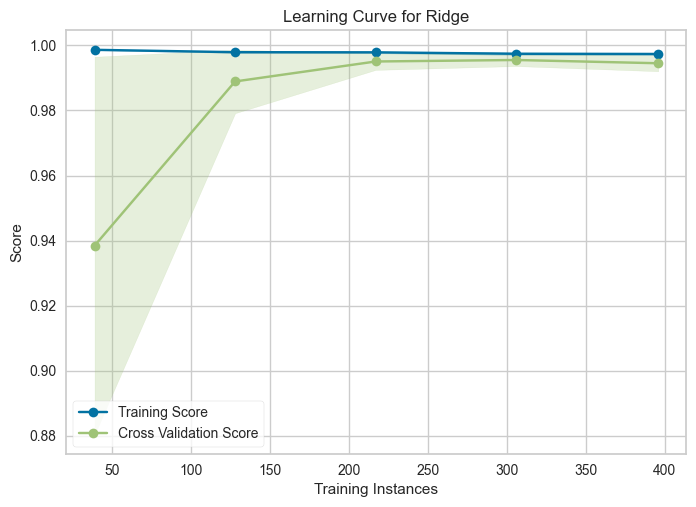

<Axes: title={'center': 'Learning Curve for Ridge'}, xlabel='Training Instances', ylabel='Score'>

In [5]:
from yellowbrick.model_selection import LearningCurve
import matplotlib.pyplot as plt

visualizer = LearningCurve(best_model, scoring='r2')
visualizer.fit(data.drop(columns=['pm_2_5']), data['pm_2_5'])
visualizer.show()


In [31]:
import pandas as pd
from pycaret.time_series import *

# 1) อ่านข้อมูล
df = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv")
df['date_only'] = pd.to_datetime(df['date_only'])
df.sort_values('date_only', inplace=True)

# 2) ตั้งค่า index เป็น timestamp และเลือกเฉพาะคอลัมน์ pm_2_5 (Univariate)
df_ts = df[['date_only', 'pm_2_5']].copy()
df_ts.set_index('date_only', inplace=True)
df_ts = df_ts.asfreq('D').interpolate()  # เติมค่าแบบ interpolation แทน ffill

# 3) สร้าง environment ด้วย setup()
ts_setup = setup(
    data=df_ts,
    target='pm_2_5',
    fh=7,
    seasonal_period=7,  # ฤดูกาลรายสัปดาห์
    session_id=123
)

# 4) เปรียบเทียบโมเดล time-series ต่าง ๆ
best_ts_model = compare_models(sort='MASE')

# 5) ปรับแต่งโมเดล (ถ้าต้องการ)
tuned_ts_model = tune_model(best_ts_model)

# 6) finalize_model เพื่อใช้จริง
final_ts_model = finalize_model(tuned_ts_model)

# 7) ทำนายอนาคต (7 วัน) โดยใช้ predict_model()
future_forecast = predict_model(final_ts_model, fh=7)

# 8) แสดงผลลัพธ์
print(future_forecast)

# 9) แสดงกราฟพยากรณ์
plot_model(final_ts_model, plot='forecast', data_kwargs={'fh': 7})


,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(499, 1)"
5,Transformed data shape,"(499, 1)"
6,Transformed train set shape,"(492, 1)"
7,Transformed test set shape,"(7, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
polytrend,Polynomial Trend Forecaster,0.7139,0.6542,3.4318,4.0941,0.5039,0.4086,-4.3033,1.0500
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.7929,0.6884,3.8131,4.3088,0.5492,0.4534,-4.5241,0.1133
grand_means,Grand Means Forecaster,0.8006,0.6533,3.8457,4.0860,0.6686,0.4414,-8.1186,1.0767
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.8383,0.7198,4.0304,4.5044,0.6359,0.4770,-5.5643,0.2167
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8505,0.7039,4.0913,4.4060,0.5524,0.4917,-4.0489,0.0800
croston,Croston,0.8551,0.7308,4.1101,4.5731,0.5942,0.4924,-5.8328,0.0167
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.8593,0.7412,4.1313,4.6384,0.6281,0.4977,-5.5998,0.2067
auto_arima,Auto ARIMA,0.8736,0.7284,4.2009,4.5586,0.5904,0.5050,-5.2062,1.9767
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8981,0.7394,4.3189,4.6275,0.6071,0.5207,-5.3022,0.1867
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.8981,0.7394,4.3189,4.6275,0.6071,0.5207,-5.3023,0.0900


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-12-02,0.8430,0.6750,4.0331,4.2136,1.0041,0.6334,-10.8145
1,2022-12-09,0.6008,0.5817,2.8884,3.6415,0.2287,0.2746,-1.7295
2,2022-12-16,0.6979,0.7059,3.3739,4.4271,0.2789,0.3178,-0.3657
Mean,NaT,0.7139,0.6542,3.4318,4.0941,0.5039,0.4086,-4.3033
SD,NaT,0.0995,0.0528,0.4691,0.3317,0.3543,0.1599,4.6377


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


            y_pred
2022-12-31  8.8863
2023-01-01  8.8794
2023-01-02  8.8725
2023-01-03  8.8656
2023-01-04  8.8587
2023-01-05  8.8518
2023-01-06  8.8449


In [39]:
import numpy as np
import pandas as pd
from pycaret.time_series import *

# 1) อ่านข้อมูล
df = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv")
df['date_only'] = pd.to_datetime(df['date_only'])
df.sort_values('date_only', inplace=True)

# 2) เตรียมข้อมูล Multivariate
df_multivar = df[['date_only', 'pm_2_5', 'temperature', 'humidity']].copy()
df_multivar.set_index('date_only', inplace=True)

# กำหนดให้เป็น daily frequency แล้ว interpolate() ถ้าข้อมูลขาดหาย (missing dates)
df_multivar = df_multivar.asfreq('D').interpolate()

# 2.1) แปลงค่า PM2.5 เป็น Log เพื่อช่วยให้โมเดลเรียนรู้แนวโน้มได้ดีขึ้น
df_multivar['pm_2_5_log'] = np.log(df_multivar['pm_2_5'] + 1)  # ใช้ log(x+1) ป้องกัน log(0)

# 3) สร้าง environment ด้วย setup()
ts_setup = setup(
    data=df_multivar,
    target='pm_2_5_log',     # ใช้คอลัมน์ log เป็น target
    fh=7,                    # ทำนายล่วงหน้า 7 วัน
    seasonal_period=7,       # เปลี่ยนจาก 'auto' เป็น 7 (รายสัปดาห์)
    session_id=123,
    fold=5
)

# 4) เปรียบเทียบโมเดล
best_ts_model = compare_models(sort='MASE')

# 5) ปรับแต่งโมเดล (Hyperparameter Tuning)
tuned_ts_model = tune_model(
    best_ts_model,
    optimize='MASE',
    search_algorithm='random',
    n_iter=50
)

# 6) finalize_model เพื่อใช้จริง
final_ts_model = finalize_model(tuned_ts_model)

# 7) พยากรณ์อนาคต (7 วัน) ในรูป log
future_forecast_log = predict_model(final_ts_model, fh=7)

# 8) แปลงค่ากลับมาเป็น PM2.5 เดิม
future_forecast = future_forecast_log.copy()
future_forecast['y_pred_original_scale'] = np.exp(future_forecast_log['y_pred']) - 1  # inverse log transform

# 9) แสดงผลลัพธ์
print("----- Future Forecast (Original PM2.5 scale) -----")
print(future_forecast[['y_pred_original_scale']])

# 10) แสดงกราฟพยากรณ์
plot_model(final_ts_model, plot='forecast', data_kwargs={'fh': 7})


,Description,Value
0,session_id,123
1,Target,pm_2_5_log
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(499, 4)"
5,Transformed data shape,"(499, 4)"
6,Transformed train set shape,"(492, 4)"
7,Transformed test set shape,"(7, 4)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.2125,0.1855,0.0925,0.1018,0.0450,0.0445,0.6932,2.8920
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.3227,0.2757,0.1408,0.1516,0.0624,0.0649,0.3884,0.1200
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.3292,0.2899,0.1435,0.1594,0.0635,0.0662,0.2819,0.1400
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.3301,0.3049,0.1440,0.1676,0.0643,0.0674,0.2386,0.0660
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.3314,0.2828,0.1444,0.1554,0.0643,0.0669,0.3083,0.1900
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.3326,0.2777,0.1449,0.1526,0.0652,0.0677,0.3592,0.1460
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.3383,0.2824,0.1474,0.1552,0.0666,0.0692,0.4255,0.0960
arima,ARIMA,0.3436,0.3040,0.1495,0.1669,0.0728,0.0727,-0.1245,0.9360
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.3506,0.2991,0.1529,0.1644,0.0678,0.0707,0.2664,0.1680
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.4419,0.3748,0.1926,0.2060,0.0845,0.0879,-0.1218,0.0820


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-11-18,0.1113,0.1089,0.0483,0.0597,0.0225,0.0229,0.8091
1,2022-11-25,0.1494,0.1229,0.0647,0.0672,0.0270,0.0274,0.9382
2,2022-12-02,0.3314,0.3028,0.1432,0.1650,0.0912,0.0856,0.3538
3,2022-12-09,0.3071,0.2484,0.1341,0.1367,0.0545,0.0561,0.4247
4,2022-12-16,0.1633,0.1444,0.0722,0.0802,0.0300,0.0306,0.9404
Mean,NaT,0.2125,0.1855,0.0925,0.1018,0.0450,0.0445,0.6932
SD,NaT,0.0891,0.0764,0.0386,0.0416,0.0256,0.0236,0.2537


Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   15.2s finished


ValueError: Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.

In [51]:
import numpy as np
import pandas as pd

# ติดตั้ง PyCaret เวอร์ชันล่าสุดก่อน (หากยังไม่ได้ติดตั้ง)
# !pip install --upgrade pycaret

from pycaret.time_series import *


# ------------------------------------------------------------------------------
# 1) อ่านข้อมูล
# ------------------------------------------------------------------------------
df_raw = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv")  # Path ที่คุณอัปโหลดใน session
df_raw['date_only'] = pd.to_datetime(df_raw['date_only'])
df_raw.sort_values('date_only', inplace=True)

# ------------------------------------------------------------------------------
# 2) เตรียมข้อมูล
#    - สร้างคอลัมน์ log สำหรับ pm_2_5 (Manual Log Transform)
#    - เลือกเฉพาะคอลัมน์ที่ต้องการเป็น target + exogenous
# ------------------------------------------------------------------------------
df_raw.set_index('date_only', inplace=True)

# *** บังคับเป็น PeriodIndex (ความถี่รายวัน) เพื่อลดปัญหา Datetime vs Period ***
df_raw.index = df_raw.index.to_period('D')

# สร้างคอลัมน์ log
df_raw['pm_2_5_log'] = np.log(df_raw['pm_2_5'] + 1)  # กัน log(0)

# เลือกเฉพาะคอลัมน์ที่ใช้จริง -> target = pm_2_5_log, exogenous = temp, humidity
df = df_raw[['pm_2_5_log', 'temperature', 'humidity']].copy()

# *** กำหนดความถี่เป็นรายวัน และ interpolate ค่า missing ***
df = df.asfreq('D').interpolate()

# ------------------------------------------------------------------------------
# 3) ตั้งค่า PyCaret (setup)
#    - fh=7  -> พยากรณ์ล่วงหน้า 7 วัน
#    - fold=7 -> เพิ่มการ Cross-Validate เพื่อให้ประเมินได้แม่นยำขึ้น
# ------------------------------------------------------------------------------
ts_setup = setup(
    data=df,
    target='pm_2_5_log',
    fh=7,                   # พยากรณ์ล่วงหน้า 7 วัน
    seasonal_period=365,      # คาดว่ามี pattern รายสัปดาห์
    session_id=123,
    fold=7                  # ใช้ 7 folds เพิ่มความน่าเชื่อถือ
)

# ------------------------------------------------------------------------------
# 4) Compare Models -> จัดลำดับโมเดลจากค่า MASE
# ------------------------------------------------------------------------------
best_ts_model = compare_models(sort='R2')

# ------------------------------------------------------------------------------
# 5) จูนโมเดล (Hyperparameter Tuning)
#    - เพิ่ม n_iter=100 เพื่อสุ่มหาพารามิเตอร์มากขึ้น
# ------------------------------------------------------------------------------
tuned_ts_model = tune_model(
    best_ts_model,
    optimize='R2',
    search_algorithm='random',  # random search
    n_iter=100
)

# ------------------------------------------------------------------------------
# 6) Finalize Model -> ล็อกโมเดลสำหรับใช้งานจริง
# ------------------------------------------------------------------------------
final_ts_model = finalize_model(tuned_ts_model)

# ------------------------------------------------------------------------------
# 7) สร้าง DataFrame Exogenous สำหรับอนาคต 7 วัน
#    (อาจต้องใช้โมเดลอื่นพยากรณ์ temp, humidity ถ้ามีข้อมูล; หรือใช้วิธีคาดเดา)
# ------------------------------------------------------------------------------
# ตัวอย่างใช้ค่าเฉลี่ย (mean) ของ temp, humidity
last_period = df.index[-1]  # เช่น Period('2023-03-10', 'D')
future_dates = pd.period_range(start=last_period + 1, periods=7, freq='D')

future_exog = pd.DataFrame(index=future_dates)
future_exog['temperature'] = df['temperature'].mean()
future_exog['humidity'] = df['humidity'].mean()

# ------------------------------------------------------------------------------
# 8) พยากรณ์อนาคต (7 วัน) โดยส่ง X=future_exog
# ------------------------------------------------------------------------------
future_forecast_log = predict_model(final_ts_model, fh=7, X=future_exog)

# ------------------------------------------------------------------------------
# 9) Inverse Transform -> ย้อนกลับจาก log -> PM2.5
# ------------------------------------------------------------------------------
future_forecast = future_forecast_log.copy()
future_forecast['y_pred_original_scale'] = np.exp(future_forecast['y_pred']) - 1

# ------------------------------------------------------------------------------
# 10) แสดงผลลัพธ์ + Plot
# ------------------------------------------------------------------------------
print("----- Future Forecast (PM2.5 scale) -----")
print(future_forecast[['y_pred_original_scale']])

# แสดงกราฟพยากรณ์
plot_model(final_ts_model, plot='forecast', data_kwargs={'fh': 7, 'X': future_exog})


,Description,Value
0,session_id,123
1,Target,pm_2_5_log
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(499, 3)"
5,Transformed data shape,"(499, 3)"
6,Transformed train set shape,"(492, 3)"
7,Transformed test set shape,"(7, 3)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.1472,1.0445,0.2825,0.3354,0.1285,0.1308,-1.1651,0.1057
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.2283,1.0924,0.3026,0.3509,0.1441,0.1402,-1.5027,0.0486
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.2283,1.0924,0.3026,0.3509,0.1441,0.1402,-1.5027,0.0514
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.2298,1.1499,0.3029,0.3693,0.1325,0.1411,-1.5376,0.0457
arima,ARIMA,1.3530,1.1569,0.3333,0.3716,0.1624,0.1530,-1.7478,0.9971
auto_arima,Auto ARIMA,1.3318,1.1422,0.3279,0.3667,0.1564,0.1515,-1.9674,2.1671
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.3558,1.1874,0.3338,0.3812,0.1487,0.1553,-2.2265,0.0486
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.3671,1.2014,0.3367,0.3858,0.1475,0.1571,-2.4207,0.0457
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.3698,1.2031,0.3373,0.3863,0.1478,0.1574,-2.4375,0.0471
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.3732,1.2052,0.3382,0.3870,0.1482,0.1578,-2.4584,0.1486


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-11-04,1.0166,0.9405,0.2505,0.3026,0.1083,0.1134,-0.1153
1,2022-11-11,1.1772,1.0677,0.2907,0.3436,0.1465,0.1444,-0.2581
2,2022-11-18,0.2752,0.2733,0.0685,0.0885,0.0339,0.0334,0.5801
3,2022-11-25,1.2654,1.2116,0.3125,0.3900,0.1194,0.1303,-1.0862
4,2022-12-02,1.4477,1.2374,0.3567,0.3972,0.2229,0.1952,-2.7430
5,2022-12-09,1.6646,1.3345,0.4086,0.4270,0.1626,0.1782,-4.6096
6,2022-12-16,1.4434,1.4102,0.3538,0.4512,0.1353,0.1507,-0.8853
Mean,NaT,1.1843,1.0679,0.2916,0.3429,0.1327,0.1351,-1.3025
SD,NaT,0.4189,0.3556,0.1026,0.1136,0.0531,0.0487,1.6595


Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:   23.7s finished


----- Future Forecast (PM2.5 scale) -----
            y_pred_original_scale
2022-12-31               8.123924
2023-01-01               8.118452
2023-01-02               8.113893
2023-01-03               8.109338
2023-01-04               8.104784
2023-01-05               8.100233
2023-01-06               8.095684


In [54]:
import numpy as np
import pandas as pd

# ติดตั้ง / อัปเดต PyCaret ให้เป็นเวอร์ชันล่าสุด (ถ้ายังไม่ทำ)
# !pip install --upgrade pycaret

from pycaret.time_series import *

# ------------------------------------------------------------------------------
# 1) อ่านข้อมูล
# ------------------------------------------------------------------------------
df_raw = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv")  # path ของไฟล์ CSV
df_raw['date_only'] = pd.to_datetime(df_raw['date_only'])
df_raw.sort_values('date_only', inplace=True)

# ------------------------------------------------------------------------------
# 2) เตรียมข้อมูล
#    2.1) ตั้งค่า index เป็น PeriodIndex (ลดปัญหา Datetime vs Period)
#    2.2) จัดการ Missing (ด้วย interpolate)
#    2.3) ตัด Outlier (ถ้าต้องการ)
#    2.4) Log Transform (Manual)
#    2.5) เลือกคอลัมน์ที่จะใช้จริง (target + exogenous)
# ------------------------------------------------------------------------------
df_raw.set_index('date_only', inplace=True)

# -> บังคับให้เป็น PeriodIndex ความถี่รายวัน
df_raw.index = df_raw.index.to_period('D')

# -> กำหนด asfreq('D') และ interpolate() (กรณีมี Missing)
df_raw = df_raw.asfreq('D').interpolate()

# (Optional) ตัด Outlier จากคอลัมน์ pm_2_5
# ตัวอย่างวิธีแบบ IQR
Q1 = df_raw['pm_2_5'].quantile(0.25)
Q3 = df_raw['pm_2_5'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
# ถ้า pm_2_5 อยู่นอกช่วงนี้ จะทำการ "clip" หรือ "winsorize"
df_raw['pm_2_5'] = df_raw['pm_2_5'].clip(lower_bound, upper_bound)

# สร้างคอลัมน์ log
df_raw['pm_2_5_log'] = np.log(df_raw['pm_2_5'] + 1)  # ป้องกัน log(0)

# เลือกเฉพาะคอลัมน์ที่จะใช้
#  -> Target = pm_2_5_log
#  -> Exogenous = temp, humidity (สมมุติว่ามีแค่ 2 ตัวแปรนี้)
df = df_raw[['pm_2_5_log', 'temperature', 'humidity']].copy()

# ------------------------------------------------------------------------------
# 3) สร้าง Environment ด้วย setup() 
#    - fh=7 => พยากรณ์ล่วงหน้า 7 วัน
#    - fold=7 => Cross Validation 7 ชุด
#    - seasonal_period=7 => จับฤดูกาลรายสัปดาห์ (ปรับตามจริงได้)
# ------------------------------------------------------------------------------
ts_setup = setup(
    data=df,
    target='pm_2_5_log',
    fh=7,
    seasonal_period=365,
    session_id=123,
    fold=7  # เพิ่ม fold เพื่อให้ประเมินได้หลากหลายขึ้น
)

# ------------------------------------------------------------------------------
# 4) Compare Models (ดูว่าโมเดลไหน MASE ต่ำสุด)
# ------------------------------------------------------------------------------
best_ts_model = compare_models(sort='MASE')

# ------------------------------------------------------------------------------
# 5) ปรับแต่งโมเดล (Hyperparameter Tuning)
#    - เพิ่ม n_iter ให้มาก (เช่น 200) เพื่อค้นหาพารามิเตอร์ที่ดียิ่งขึ้น
# ------------------------------------------------------------------------------
tuned_ts_model = tune_model(
    best_ts_model,
    optimize='MASE',
    search_algorithm='random',
    n_iter=200
)

# ------------------------------------------------------------------------------
# 6) (Optional) Ensemble โมเดล
#    - บางเวอร์ชันของ PyCaret อาจมีฟังก์ชัน ensemble_model() สำหรับ time_series
#    - ถ้ามี error แสดงว่าเวอร์ชันนั้นยังไม่รองรับ ให้ข้ามขั้นตอนนี้ไป
# ------------------------------------------------------------------------------
try:
    ens_ts_model = ensemble_model(tuned_ts_model, method='auto')  # หรือ "bagging", "boosting"
except:
    ens_ts_model = tuned_ts_model

# ------------------------------------------------------------------------------
# 7) Finalize Model (ล็อกโมเดล)
# ------------------------------------------------------------------------------
final_ts_model = finalize_model(ens_ts_model)

# ------------------------------------------------------------------------------
# 8) สร้างข้อมูล Exogenous สำหรับ 7 วันข้างหน้า
#    - ถ้ามีวิธีคาดการณ์ temp, humidity ล่วงหน้าจริง ๆ ให้ใช้
#      ที่นี่ใช้ค่าเฉลี่ยเป็นตัวอย่าง
# ------------------------------------------------------------------------------
last_period = df.index[-1]  # ตัวอย่างเช่น Period('2023-03-10', 'D')
future_dates = pd.period_range(start=last_period + 1, periods=7, freq='D')

future_exog = pd.DataFrame(index=future_dates)
future_exog['temperature'] = df['temperature'].mean()       # หรือโมเดลพยากรณ์ temp อื่น ๆ
future_exog['humidity'] = df['humidity'].mean()

# ------------------------------------------------------------------------------
# 9) ทำนายอนาคต (7 วัน) + ย้อนกลับสเกล Log => PM2.5
# ------------------------------------------------------------------------------
future_forecast_log = predict_model(final_ts_model, fh=7, X=future_exog)

future_forecast = future_forecast_log.copy()
future_forecast['y_pred_PM2_5'] = np.exp(future_forecast['y_pred']) - 1

print("----- Future Forecast (PM2.5 scale) -----")
print(future_forecast[['y_pred_PM2_5']])

# ------------------------------------------------------------------------------
# 10) แสดงกราฟพยากรณ์
# ------------------------------------------------------------------------------
plot_model(final_ts_model, plot='forecast', data_kwargs={'fh': 7, 'X': future_exog})


,Description,Value
0,session_id,123
1,Target,pm_2_5_log
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(499, 3)"
5,Transformed data shape,"(499, 3)"
6,Transformed train set shape,"(492, 3)"
7,Transformed test set shape,"(7, 3)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.1479,1.0447,0.2825,0.3354,0.1285,0.1308,-1.1653,0.1057
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.2290,1.0926,0.3026,0.3509,0.1441,0.1402,-1.5029,0.0457
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.2290,1.0926,0.3026,0.3509,0.1441,0.1402,-1.5029,0.0457
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.2305,1.1501,0.3029,0.3693,0.1325,0.1411,-1.5378,0.0457
auto_arima,Auto ARIMA,1.3308,1.1415,0.3275,0.3665,0.1562,0.1513,-1.9482,2.6114
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.3408,1.1683,0.3300,0.3751,0.1475,0.1535,-2.1724,0.0486
arima,ARIMA,1.3532,1.1566,0.3331,0.3714,0.1624,0.1529,-1.7457,0.8114
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.3678,1.2016,0.3367,0.3858,0.1475,0.1571,-2.4209,0.0471
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.3706,1.2033,0.3373,0.3863,0.1478,0.1574,-2.4376,0.0443
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.3739,1.2054,0.3382,0.3870,0.1482,0.1578,-2.4586,0.1171


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-11-04,0.9977,0.9613,0.2457,0.3092,0.1050,0.1109,-0.1648
1,2022-11-11,1.1663,1.0832,0.2879,0.3486,0.1433,0.1434,-0.2944
2,2022-11-18,0.2474,0.2528,0.0615,0.0819,0.0300,0.0299,0.6409
3,2022-11-25,1.3215,1.2491,0.3262,0.4021,0.1250,0.1365,-1.2169
4,2022-12-02,1.3922,1.1925,0.3428,0.3827,0.2142,0.1884,-2.4755
5,2022-12-09,1.5698,1.2541,0.3851,0.4012,0.1539,0.1679,-3.9529
6,2022-12-16,1.3460,1.3255,0.3297,0.4240,0.1266,0.1395,-0.6652
Mean,NaT,1.1487,1.0455,0.2827,0.3357,0.1283,0.1309,-1.1613
SD,NaT,0.4037,0.3427,0.0989,0.1096,0.0514,0.0471,1.4522


Fitting 7 folds for each of 200 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:   45.6s finished


----- Future Forecast (PM2.5 scale) -----
            y_pred_PM2_5
2022-12-31      8.123012
2023-01-01      8.118452
2023-01-02      8.113893
2023-01-03      8.109338
2023-01-04      8.104784
2023-01-05      8.099323
2023-01-06      8.094774


In [60]:
import numpy as np
import pandas as pd

# อัปเดต PyCaret ให้ล่าสุด (เผื่อแก้บั๊กต่าง ๆ)
# !pip install --upgrade pycaret

from pycaret.time_series import *

# ------------------------------------------------------------------------------
# 1) อ่านข้อมูล
# ------------------------------------------------------------------------------
df_raw = pd.read_csv(r"C:\Users\snpdp\pm2.5-Forecast-Dashboard\Data_csv\merge_data\AeroSURE-m-1d.csv")  # ชื่อไฟล์ CSV
df_raw['date_only'] = pd.to_datetime(df_raw['date_only'])
df_raw.sort_values('date_only', inplace=True)

# ------------------------------------------------------------------------------
# 2) ตั้งค่า Index, จัดการ Missing, Log Transform, เลือกคอลัมน์
# ------------------------------------------------------------------------------
df_raw.set_index('date_only', inplace=True)

# แปลงเป็น PeriodIndex (รายวัน) ลดปัญหา DateTime vs Period
df_raw.index = df_raw.index.to_period('D')

# กำหนดความถี่ 'D' และ interpolate ค่าที่ขาด
df_raw = df_raw.asfreq('D').interpolate()

# สร้างคอลัมน์ log เพื่อให้โมเดลจับแนวโน้มได้ดีขึ้น
df_raw['pm_2_5_log'] = np.log(df_raw['pm_2_5'] + 1)

# เลือกเฉพาะคอลัมน์ที่ต้องการ -> Target + Exogenous
#   Target = pm_2_5_log
#   Exogenous = temp, humidity (ถ้ามีคอลัมน์อื่นก็เพิ่มได้)
df = df_raw[['pm_2_5_log', 'temperature', 'humidity']].copy()

# ------------------------------------------------------------------------------
# 3) Setup PyCaret (Multivariate Forecasting)
#    - fh=7 => พยากรณ์ล่วงหน้า 7 วัน
#    - seasonal_period=7 => รายสัปดาห์
#    - fold=7 => ขยายจำนวน CV folds เพื่อให้ประเมินได้มั่นใจขึ้น
#    - ignore_seasonality_test=True => บางเวอร์ชันใช้เพื่อไม่ให้เช็ค seasonality เพิ่ม
# ------------------------------------------------------------------------------
ts_setup = setup(
    data=df,
    target='pm_2_5_log',
    fh=7,
    seasonal_period=7,
    fold=7,
    session_id=123,
    ignore_seasonality_test=True  # ป้องกัน PyCaret ตรวจจับ seasonality เองจน error
)

# ------------------------------------------------------------------------------
# 4) Compare Models -> exclude โมเดลที่ใช้ ARIMA/ETS เพื่อเลี่ยง error
#    (รวมถึง naive, stlf, exp_smooth, etc. ตามความเหมาะสม)
# ------------------------------------------------------------------------------
best_ts_model = compare_models(
    sort='MASE',
    exclude=[
        'arima',       # ARIMA
        'auto_arima',  # Auto ARIMA
        'ets',         # Exponential Smoothing
        'theta',       # Theta Forecaster
        'naive',       # Naive
        'snaive',      # Seasonal Naive
        'exp_smooth',  # Exp. Smoothing
        'stlf'         # STLF
    ]
)

# ------------------------------------------------------------------------------
# 5) ปรับแต่งโมเดล (Hyperparameter Tuning)
#    - n_iter=50 หรือปรับมากขึ้น (100, 200) เพื่อค้นหาพารามิเตอร์ที่ดีกว่า
# ------------------------------------------------------------------------------
tuned_ts_model = tune_model(
    best_ts_model,
    optimize='MASE',
    search_algorithm='random',
    n_iter=50
)

# ------------------------------------------------------------------------------
# 6) (Optional) ลองทำ Ensemble (ถ้าเวอร์ชัน PyCaret รองรับ)
# ------------------------------------------------------------------------------
try:
    ens_ts_model = ensemble_model(tuned_ts_model, method='auto')
except:
    ens_ts_model = tuned_ts_model

# ------------------------------------------------------------------------------
# 7) Finalize Model
# ------------------------------------------------------------------------------
final_ts_model = finalize_model(ens_ts_model)

# ------------------------------------------------------------------------------
# 8) เตรียมข้อมูล exogenous 7 วันข้างหน้า
#    - ถ้าไม่มีข้อมูลอนาคตจริง ใช้ค่าคงที่ (ค่าเฉลี่ย) หรือโมเดลอื่นพยากรณ์
# ------------------------------------------------------------------------------
last_period = df.index[-1]  # เช่น Period('2023-03-01', 'D')
future_dates = pd.period_range(start=last_period + 1, periods=7, freq='D')

future_exog = pd.DataFrame(index=future_dates)
future_exog['temperature'] = df['temperature'].mean()
future_exog['humidity'] = df['humidity'].mean()

# ------------------------------------------------------------------------------
# 9) พยากรณ์ 7 วัน + inverse log
# ------------------------------------------------------------------------------
future_forecast_log = predict_model(final_ts_model, fh=7, X=future_exog)
future_forecast = future_forecast_log.copy()
future_forecast['y_pred_original_scale'] = np.exp(future_forecast['y_pred']) - 1

print("----- Future Forecast (PM2.5 scale) -----")
print(future_forecast[['y_pred_original_scale']])

# ------------------------------------------------------------------------------
# 10) แสดงกราฟผลการพยากรณ์
# ------------------------------------------------------------------------------
plot_model(final_ts_model, plot='forecast', data_kwargs={'fh': 7, 'X': future_exog})


,Description,Value
0,session_id,123
1,Target,pm_2_5_log
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(499, 3)"
5,Transformed data shape,"(499, 3)"
6,Transformed train set shape,"(492, 3)"
7,Transformed test set shape,"(7, 3)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.6504,0.6136,0.2835,0.3374,0.1294,0.1314,-1.1558,0.0586
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.6931,0.6639,0.3023,0.3653,0.1326,0.1408,-1.4497,0.0543
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.6956,0.6483,0.3030,0.3563,0.1447,0.1404,-1.5581,0.0571
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.6956,0.6483,0.3030,0.3563,0.1447,0.1404,-1.5581,0.0586
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7579,0.6883,0.3305,0.3786,0.1467,0.1556,-2.5492,0.0571
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7580,0.6884,0.3305,0.3786,0.1467,0.1556,-2.5513,0.0571
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7584,0.6891,0.3307,0.3790,0.1468,0.1558,-2.5698,0.0543
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.7743,0.6964,0.3377,0.3830,0.1511,0.1589,-2.7116,0.0586
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.8071,0.7379,0.3519,0.4058,0.1608,0.1638,-2.2251,0.1000
croston,Croston,0.8103,0.7366,0.3528,0.4046,0.1703,0.1635,-2.7330,0.0100


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-11-04,0.6384,0.6265,0.2787,0.3457,0.1185,0.1273,-0.4560
1,2022-11-11,0.6974,0.7217,0.3039,0.3972,0.1435,0.1519,-0.6810
2,2022-11-18,0.2168,0.1888,0.0941,0.1035,0.0459,0.0467,0.4257
3,2022-11-25,0.7736,0.7476,0.3348,0.4084,0.1290,0.1406,-1.2877
4,2022-12-02,0.6268,0.5864,0.2708,0.3196,0.1683,0.1505,-1.4236
5,2022-12-09,0.9290,0.7766,0.4057,0.4276,0.1637,0.1803,-4.6260
6,2022-12-16,0.8390,0.8160,0.3708,0.4533,0.1443,0.1594,-0.9027
Mean,NaT,0.6744,0.6377,0.2941,0.3508,0.1305,0.1367,-1.2788
SD,NaT,0.2122,0.1980,0.0933,0.1096,0.0382,0.0397,1.4787


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:   14.7s finished


----- Future Forecast (PM2.5 scale) -----
            y_pred_original_scale
2022-12-31               8.699749
2023-01-01               8.046700
2023-01-02               8.034043
2023-01-03               8.391453
2023-01-04               7.896874
2023-01-05               7.804826
2023-01-06               8.501978
